# Data Exploration and Cleaning

First, we will explore this data using various methods and also clean it for use in the models


In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import  Counter
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
import spacy
import gensim
import nltk
from nltk.tokenize import word_tokenize

df = pd.read_csv('sample_data.csv')
df.head()

,text,label
0,zucker fabrik,ft
1,Lebensmittel kommssionierung,ft
2,geländer biegen,mr
3,gebäudeausrüstung technische,ct
4,kürbiskernöl softgels,ft


## Data Cleaning
After browsing around in the data, several anamolies and noise were found in the dataset, we will deal with them one by one

#### Nan in Label
we found nan values in the label, which cannot be utilised to make sense our data, we will get rid of them.

In [34]:
print(df[df['label'].isna()].shape)
df = df.dropna(subset=['label'])

(100, 2)


We can see that there were 100 inputs with no label, we have cleaned it from our dataset. One argument against it could be that sometimes having the nan data impoves the model accuracy but in our case, the amount of nan data (100) is very less compared to our data size (37295).

#### Email id input
we found inputs with just email addresses in the search query, we will explore it and see if it has any significance to the classification.
We can check how it is distributed among the classes to understand if it is relevant to us


<Axes: xlabel='label'>

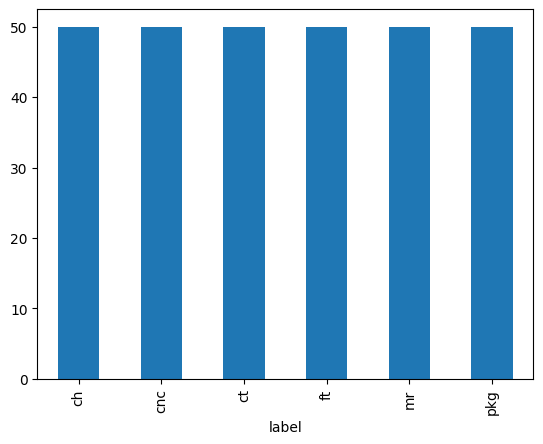

In [35]:
email_pattern = re.compile(r'\b[\w.-]+@[\w.-]+\.\w+\b')

# We create a mask to identify emial ids
contains_email_mask = df['text'].str.contains(email_pattern)

emails_df = df[contains_email_mask]

#plot its ditribution
emails_df.groupby('label').text.count().plot.bar(ylim=0)

We can see that it is distributed equally among all classes, as in, it is basically noise added and can affect our models perfomance. We will eliminate this Data.


In [36]:
contains_email_mask = df['text'].str.contains(email_pattern, na=False)

# remove it by inverting mask
df = df[~contains_email_mask]

#### Number sequence
we spotted some inputs with only a number sequence like a phone number, we will check its distribution and analyse if it is relevant to us.

<Axes: xlabel='label'>

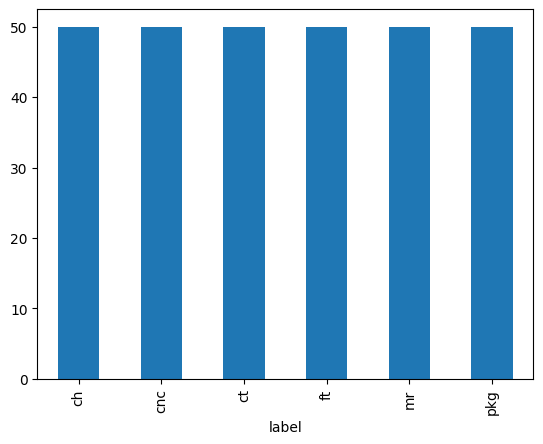

In [37]:
mask = df['text'].str.match(r'^\d+$')

numbers_only_df = df[mask]

# plot its distribution
numbers_only_df.groupby('label').text.count().plot.bar(ylim=0)

From its equal distribution, we can see that it is noise similar to email ids that we can clean from our Data.

In [38]:
mask = df['text'].str.match(r'^\d+$')

#remove it 
df = df[~mask]

#### Chinease Character and blankspaces
We also found several inputs with blankspaces and chinease language scriptures, we will check their distribution.

<Axes: xlabel='label'>

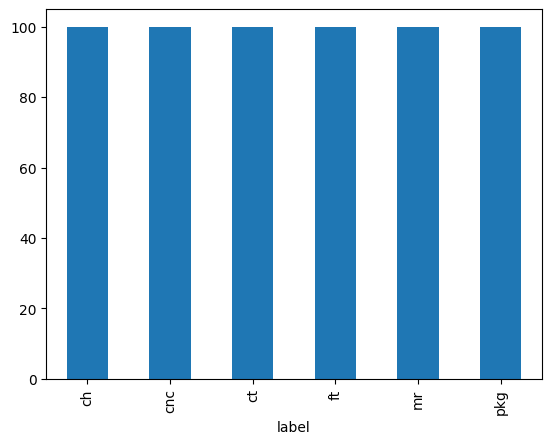

In [39]:
non_ascii_pattern = re.compile(r'[^\u0021-\u007E]+')

def contains_only_non_ascii_or_space(text):
    # Remove spaces from the text
    text_no_spaces = re.sub(r'[\s]', '', text) 
    # Find all non-ASCII parts
    non_ascii_parts = non_ascii_pattern.findall(text_no_spaces)
    non_ascii_text = ''.join(non_ascii_parts)
    return len(non_ascii_text) == len(text_no_spaces)

mask = df['text'].apply(contains_only_non_ascii_or_space)

strict_non_ascii_df = df[mask]

# plot 
strict_non_ascii_df.groupby('label').text.count().plot.bar(ylim=0)

We can see that this is also noice that is evenly distributed, and we will clean it.


In [41]:
mask = df['text'].apply(contains_only_non_ascii_or_space)

# remove it
df = df[~mask]


We have cleaned all the unwanted data we spotted, we have 35995 rows left, after removing 1300 unwanted data in total.

## Data Exploration
We will now explore our data looks visually to gain a better understanding of it.

#### Number of characters present in text

<Axes: >

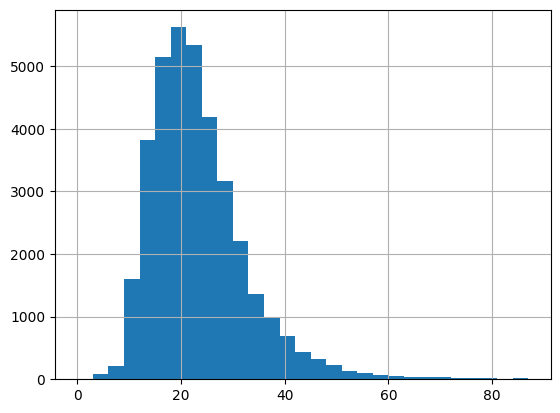

In [43]:
df['text'].str.len().hist(bins=range(0, 90, 3))

The histogram shows that search queries range from 5 to 80 characters and generally, it is between 15 to 30 characters.

#### number of words in input

<Axes: >

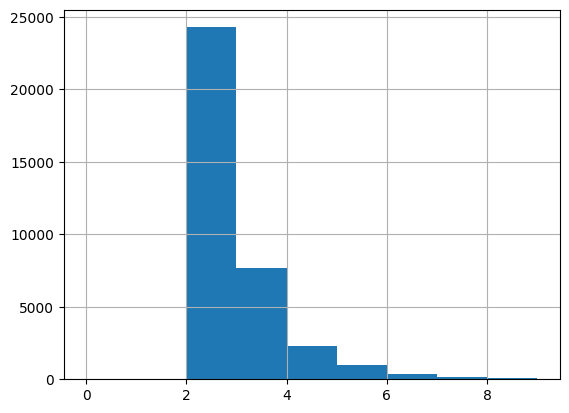

In [44]:
df['text'].str.split().map(lambda x: len(x)).hist(bins=range(0, 10, 1))

It is clear that the number of words in search queries ranges from 2 to 10 and mostly falls between 2 to 4 words.


This information will be usefull in deciding **ngrams** in our model building stages. 

#### Average word length

<Axes: >

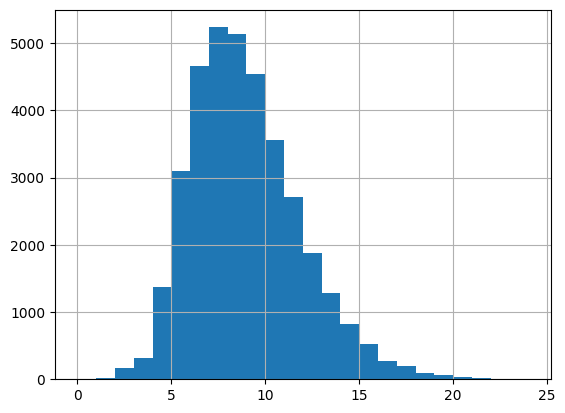

In [45]:
df['text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist(bins=range(0, 25, 1))

The average word length ranges between 1 to 23 with 7 being the most common length. Does it mean that people are using relatively short words in search queries?
One reason why this may not be true is stopwords


#### Stopwords frequency
Lets see the stopwords and how frequenlty they occur in our search query dataset.

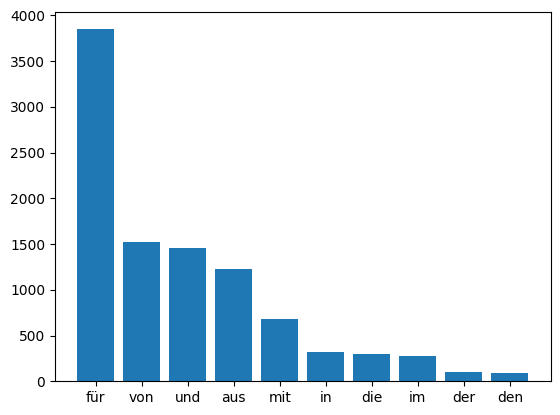

In [47]:
german_stopwords = set(stopwords.words("german"))

def plot_top_stopwords_barchart(text):
    stop=german_stopwords
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)
    
plot_top_stopwords_barchart(df['text'])

We can see stopwords and their distribution. They are around 9000 range, they do have a good presence in the dataset. These do not help when we model, as these words do not provide indication to the label of the text. 

#### Word frequency (excluding stopwords)
Lets analyse how frequenlty non stop words are occuring, this can give us many insights later on.

/var/folders/9w/v_6mll4x36b4460bdrs28yq00000gp/T/ipykernel_4499/2576504927.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=y,y=x, palette=colors)


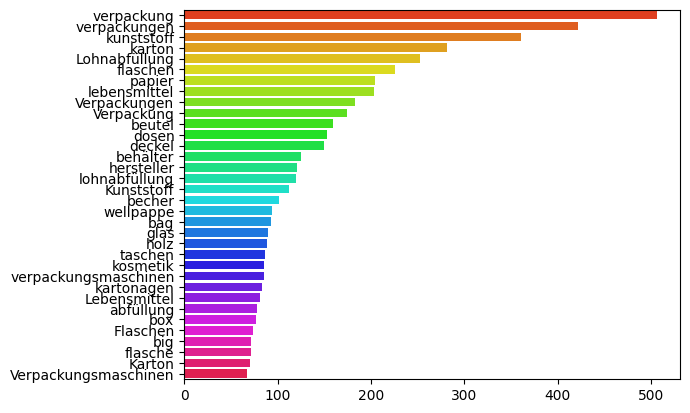

In [51]:
def plot_top_non_stopwords_barchart(text):
    stop=german_stopwords
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
    colors = sns.color_palette('hsv', len(x))        
    sns.barplot(x=y,y=x, palette=colors)

plot_top_non_stopwords_barchart(df[df['label']== 'pkg'].text)


One useful observation from this that already just one word has relevance to their classes, this means we can use a lower ngram when in use.

#### NGram Exploration
lets see how two ngrams look in this distribution.


/var/folders/9w/v_6mll4x36b4460bdrs28yq00000gp/T/ipykernel_4499/3894726691.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=y,y=x, palette = colors)


<Axes: >

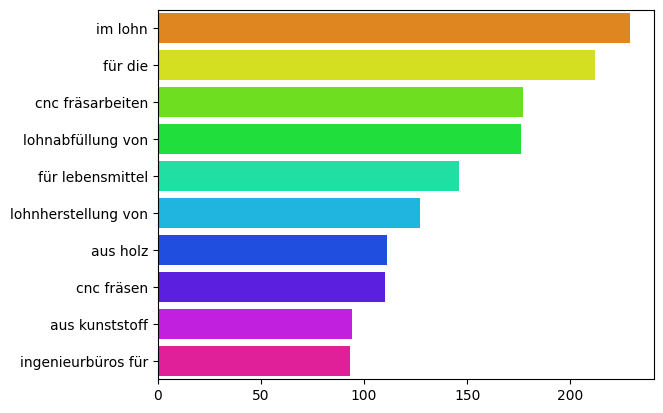

In [59]:

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]


top_n_bigrams=get_top_ngram(df['text'],2)[:10] 
x,y=map(list,zip(*top_n_bigrams)) 
colors = sns.color_palette('hsv', len(x))        

sns.barplot(x=y,y=x, palette = colors)    


We see that most bigrams have a stopword, and hence might not be much useful. Lets explore trigrams

/var/folders/9w/v_6mll4x36b4460bdrs28yq00000gp/T/ipykernel_4499/3019044029.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=y,y=x, palette = colors)


<Axes: >

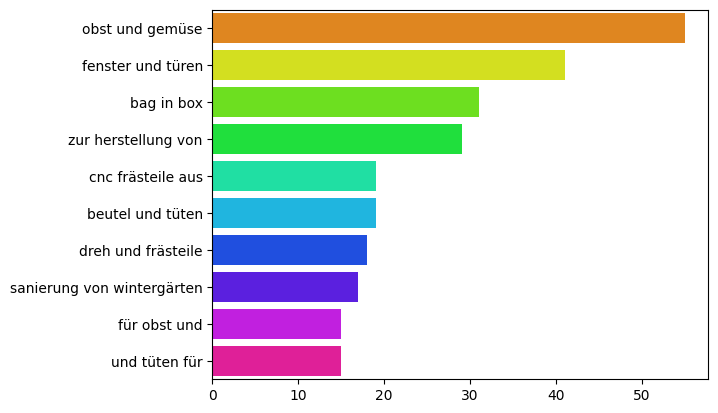

In [60]:
top_n_bigrams=get_top_ngram(df['text'],3)[:10] 
x,y=map(list,zip(*top_n_bigrams)) 
colors = sns.color_palette('hsv', len(x))        

sns.barplot(x=y,y=x, palette = colors)  

We can observe that this might be a better indicator of their respective label classes.

#### Topic modeling exploration with pyLDAvis
we can use pyLDAvis, which uses unspuervised learning techniques to extract the main topics that occur in a collection of documents. We can check if this is able to seperate our topics without providing the labels.

In [79]:
import pyLDAvis.gensim
from nltk.stem import WordNetLemmatizer,PorterStemmer


german_stopwords = stopwords.words('german')



def get_lda_objects(text):
    stop=german_stopwords
    
    def _preprocess_text(text):
        corpus=[]
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    dic=gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]
    
    lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 6, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
    
    return lda_model, bow_corpus, dic

def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
    return vis

In [80]:
lda_model, bow_corpus, dic = get_lda_objects(df['text'])
plot_lda_vis(lda_model, bow_corpus, dic)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.068485 -0.230025       1        1  17.419526
3     -0.249111  0.049200       2        1  17.086931
4      0.120307 -0.091626       3        1  16.771203
0      0.002961  0.163180       4        1  16.608392
1      0.062646  0.106409       5        1  16.168789
2      0.131683  0.002862       6        1  15.945159, topic_info=               Term        Freq       Total Category  logprob  loglift
30              cnc  914.000000  914.000000  Default  30.0000  30.0000
203    lebensmittel  673.000000  673.000000  Default  29.0000  29.0000
33       verpackung  424.000000  424.000000  Default  28.0000  28.0000
192             bio  412.000000  412.000000  Default  27.0000  27.0000
2      Lebensmittel  376.000000  376.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
400           Dosen   34.893833   35.550663   Topic6  -5.9049   1.8174
880    maschinenbau   34.015047   34.671797   Topic6  -5.9304   1.8169
1273          Türen   33.594858   34.251102   Topic6  -5.9428   1.8167
2023          pizza   46.896258   60.348277   Topic6  -5.6092   1.5838
47    Lohnabfüllung   55.199138  226.427291   Topic6  -5.4462   0.4245

[239 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
1899      5  0.985819           Bau
2222      5  0.973531  Baumaschinen
218       3  0.021666        Beutel
218       5  0.974949        Beutel
146       1  0.997376           Bio
...     ...       ...           ...
429       5  0.986495          wein
468       6  0.990030         weine
257       5  0.993591     wellpappe
1044      3  0.981508    zerspanung
1         1  0.976070        zucker

[231 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 4, 5, 1, 2, 3])

we can explore here and see that an unspurvised model is able to catogeroise it into 6 topics, but not very effectively as some do haev clos overlaps. 

Another observation is that although the most common words in these overlap in differnet topics, they only do so slightly and **common words** are a **good indicator** of their **labels** in our dataset.